## spaCy Model Customization

### Create Custom Text Categorizer

Documentation: https://spacy.io/api/textcategorizer

In [1]:
import spacy
import random
from pathlib import Path
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from spacy import displacy
sns.set_style("whitegrid")

#typically a couple hundred examples are required for accurate results 
train_data = [
    (u"Malta", {'cats': {'EUROPEAN': 1.0, 'NA': 0.0}}),
    (u"Crete", {'cats': {'EUROPEAN': 1.0, 'NA': 0.0}}),
    (u"USA", {'cats': {'EUROPEAN': 0.0, 'NA': 1.0}}),
    (u"British", {'cats': {'EUROPEAN': 1.0, 'NA': 0.0}}),
    (u"Brazil", {'cats': {'EUROPEAN': 0.0, 'NA': 1.0}}),
    (u"Canadian", {'cats': {'EUROPEAN': 0.0, 'NA': 1.0}}),
    (u"Sweden", {'cats': {'EUROPEAN': 1.0, 'NA': 0.0}})]

C:\Users\casocha\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\Users\casocha\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [2]:
def cat_main(model='en_core_web_sm', new_model_name='ROLL_TIDE', output_dir=r'file_path', n_iter=10):
    """Set up the pipeline and entity recognizer, and train the new entity."""
    if model is not None:
        #loads pre-trained spacy en model - other options available here: https://spacy.io/usage/models
        #nlp = spacy.load('en_core_web_sm') ~ set model in function to the string value
        
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:        
        # create blank Language class
        nlp = spacy.blank('en') 
        print("Created'en' model")


    #initialize nlp pipeline
    textcat = nlp.create_pipe('textcat')
    nlp.add_pipe(textcat, last=True)

    #add custom categories
    textcat.add_label('EUROPEAN')
    textcat.add_label('NA')

    #begin training
    nlp.vocab.vectors.name = 'spacy_pretrained_vectors'
    optimizer = nlp.begin_training()
    
    lose=[]
    for itn in range(10):
        losses = {}
        
        for doc, gold in train_data:
            nlp.update([doc], [gold], sgd=optimizer,losses=losses)
        #print(losses)
        lose.append(losses['textcat'])

        return_l = pd.DataFrame(lose)
        return_l = return_l.reset_index()
        return_l['index'] = return_l['index'] + 1

        clear_output(wait=True)
        ax = sns.pointplot(x="index", y=0, data=return_l)
        plt.xlabel('Run #')
        plt.ylabel('Loss')
        plt.title('Tracking Loss Over Training Iterations')
        plt.show()

    #output model to be used later 
    #output_dir = r'file path'
    output_dir = Path(output_dir) 
    if not output_dir.exists():
        output_dir.mkdir()
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)
        
    #load the saved model
    print("Loading from", output_dir)
    nlp = spacy.load(output_dir)
    #test the model
    doc = nlp(u'Italy')
    print('Test Cats:')
    print(doc.cats)
        
    return nlp

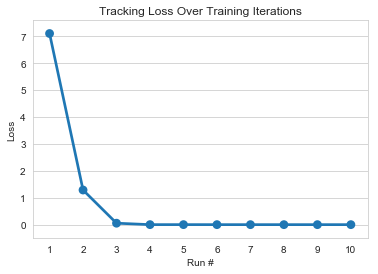

Loading from file_path
Test Cats:
{'EUROPEAN': 0.1147436872124672, 'NA': 0.6383675932884216}


In [3]:
text_cat_nlp = cat_main()

### Create Custom Entity Recognition & Update Pre-Existing Entities

In [4]:
import spacy
import random
from pathlib import Path
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from spacy import displacy
sns.set_style("whitegrid")

# new entity label
LABEL = 'ROLL_TIDE'

TRAIN_DATA = [
    ("Feb", {
        'entities': [(0, 2, 'DATE')]
    }),

    ("15/16E", {
        'entities': [(0, 5, 'DATE')]
    }),

    ("Apr 20", {
        'entities': [(0, 6, 'DATE')]
    }),
   
    ("Nick Saban", {
        'entities': [(0, 10, 'ROLL_TIDE')]
    }),
    ("Crimson Tide", {
        'entities': [(0, 12, 'ROLL_TIDE')]
    }),

    ("Big Al", {
        'entities': [(0, 6, 'ROLL_TIDE')]
    }),
    ("Tua 4 Heisman", {
        'entities': [(0, 13, 'ROLL_TIDE')]
    })]

In [5]:
def main(model='en_core_web_sm', new_model_name='ROLL_TIDE', output_dir=r'file_path', n_iter=10):
    
    """Set up the pipeline and entity recognizer, and train the new entity."""
    if model is not None:
        #loads pre-trained spacy en model - other options available here: https://spacy.io/usage/models
        #nlp = spacy.load('en_core_web_sm') ~ set model in function to the string value
        
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:        
        # create blank Language class
        nlp = spacy.blank('en') 
        print("Created'en' model")
        
    # Add entity recognizer to model if it's not in the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    # otherwise, get it, so we can add labels to it
    else:
        ner = nlp.get_pipe('ner')
    
    # add new entity label to entity recognizer
    ner.add_label(LABEL)   
    
    #prepares model for training
    if model is None:
        nlp.vocab.vectors.name = 'spacy_pretrained_vectors'
        optimizer = nlp.begin_training()
    else:
        # Note that 'begin_training' initializes the models, so it'll zero out
        # existing entity types.
        optimizer = nlp.entity.create_optimizer()
    
    lose = []
    run_index = []
    x = 0
    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        for itn in range(n_iter):
            random.shuffle(TRAIN_DATA)
            losses = {}
            for text, annotations in TRAIN_DATA:
                nlp.update([text], [annotations], sgd=optimizer, drop=0.35,
                           losses=losses)
           # print(losses)
            lose.append(losses['ner'])
            
            return_l = pd.DataFrame(lose)
            return_l = return_l.reset_index()
            return_l['index'] = return_l['index'] + 1
            clear_output(wait=True)
            ax = sns.pointplot(x="index", y=0, data=return_l)
            plt.xlabel('Run #')
            plt.ylabel('Loss')
            plt.title('Loss ')
            plt.title('Tracking Loss Over Training Iterations')
            plt.show()
            
    # test the trained model
    test_text = "Tua will win the heisman for Nick Saban"
    doc = nlp(test_text)
    
    print("Entities in '%s'" % test_text)
    for ent in doc.ents:
        print(ent.label_, ent.text)
    
    #visualize entities returned
    colors = {'ROLL_TIDE': 'linear-gradient(90deg, #aa9cfc, #fc9ce7)'}
    options = {'ents': ['ROLL_TIDE'], 'colors': colors}
    displacy.serve(doc, style='ent', options=options)
    #Go to: http://localhost:5000
    
    #output model to be used later 
    #output_dir = r'file path'
    output_dir = Path(output_dir) 
    if not output_dir.exists():
        output_dir.mkdir()
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)
        
    #load the saved model
    print("Loading from", output_dir)
    nlp = spacy.load(output_dir)
    #test the model
    doc = nlp(u'Italy')
    print('Test Cats:')
    print(doc.cats)
   
    return nlp

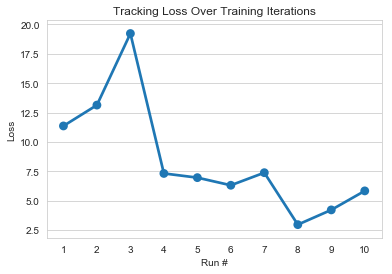

Entities in 'Tua will win the heisman for Nick Saban'
ROLL_TIDE Tua will
ROLL_TIDE Nick Saban

    Serving on port 5000...
    Using the 'ent' visualizer



In [ ]:
bama_nlp = main()